### Cross-Validation

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import calendar
import pickle
import time

%matplotlib inline
plt.style.use('seaborn-pastel')

import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from collections import defaultdict, Counter

%run evaluation_functions.py

In [13]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)

In [14]:
with open('pickles/appt.pickle','rb') as read_file:
    appt = pickle.load(read_file)
with open('pickles/appt_v2.pickle','rb') as read_file:
    appt_v2 = pickle.load(read_file)
with open('pickles/appt_v2_all0.pickle','rb') as read_file:
    appt_v3 = pickle.load(read_file)
with open('pickles/appt_v2_all1.pickle','rb') as read_file:
    appt_v4 = pickle.load(read_file)

In [15]:
#Set features
# run for appt - all appts, basic features
feature_cols = ['Gender','Age','Scholarship','Hipertension','Diabetes','Alcoholism','Handcap','SMS_received',
                'ApptDayofWeek','SchedDayofWeek','Neighbourhood','DayDiff']
a_Xv1 = appt[feature_cols]
a_Xv1 = pd.get_dummies(a_Xv1, columns = ['Gender','Neighbourhood','ApptDayofWeek','SchedDayofWeek'])
a_Xv1.drop(columns=['Gender_F','Neighbourhood_VILA RUBIM','SchedDayofWeek_Monday','ApptDayofWeek_Monday'],inplace=True)
Xv1_cols = np.array(a_Xv1.columns)
a_Xv1.info()

## run for appt_v2 - second or more appts, adds historical features
feature_cols = ['Gender','Age2','Neighbourhood2','Scholarship','Hipertension','Diabetes','Alcoholism',
                'Handcap_bin','SMS_received','SchedDayofWeek','ApptDayofWeek','DayDiff2',
                'no_show_rate2','Reschedule','Follow_up']
a_Xv2 = appt_v2[feature_cols]
a_Xv2 = pd.get_dummies(a_Xv2, columns = ['Gender','Neighbourhood2','SchedDayofWeek','ApptDayofWeek'])
a_Xv2.drop(columns=['Gender_F','Neighbourhood2_OTHER','SchedDayofWeek_Monday','ApptDayofWeek_Monday'],inplace=True)
Xv2_cols = np.array(a_Xv2.columns)
a_Xv2.info()
# a_X.head(5)

## run for appt_v2_all0 - all appts, replaces no-show-rate NA's as 0's
feature_cols = ['Gender','Age2','Neighbourhood2','Scholarship','Hipertension','Diabetes','Alcoholism',
                'Handcap_bin','SMS_received','SchedDayofWeek','ApptDayofWeek','DayDiff2',
                'no_show_rate2','Reschedule','Follow_up']
a_Xv3 = appt_v3[feature_cols]
a_Xv3 = pd.get_dummies(a_Xv3, columns = ['Gender','Neighbourhood2','SchedDayofWeek','ApptDayofWeek'])
a_Xv3.drop(columns=['Gender_F','Neighbourhood2_OTHER','SchedDayofWeek_Monday','ApptDayofWeek_Monday'],inplace=True)
Xv3_cols = np.array(a_Xv3.columns)
a_Xv3.info()

## run for appt_v2_all1 - all appts, replaces no-show-rate NA's as imputed from linreg's
feature_cols = ['Gender','Age2','Neighbourhood2','Scholarship','Hipertension','Diabetes','Alcoholism',
                'Handcap_bin','SMS_received','SchedDayofWeek','ApptDayofWeek','DayDiff2',
                'no_show_rate2','Reschedule','Follow_up']
a_Xv4 = appt_v4[feature_cols]
a_Xv4 = pd.get_dummies(a_Xv4, columns = ['Gender','Neighbourhood2','SchedDayofWeek','ApptDayofWeek'])
a_Xv4.drop(columns=['Gender_F','Neighbourhood2_OTHER','SchedDayofWeek_Monday','ApptDayofWeek_Monday'],inplace=True)
Xv4_cols = np.array(a_Xv4.columns)
a_Xv4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71163 entries, 0 to 71958
Data columns (total 97 columns):
Age                                          71163 non-null int64
Scholarship                                  71163 non-null int64
Hipertension                                 71163 non-null int64
Diabetes                                     71163 non-null int64
Alcoholism                                   71163 non-null int64
Handcap                                      71163 non-null int64
SMS_received                                 71163 non-null int64
DayDiff                                      71163 non-null int64
Gender_M                                     71163 non-null uint8
Neighbourhood_AEROPORTO                      71163 non-null uint8
Neighbourhood_ANDORINHAS                     71163 non-null uint8
Neighbourhood_ANTÔNIO HONÓRIO                71163 non-null uint8
Neighbourhood_ARIOVALDO FAVALESSA            71163 non-null uint8
Neighbourhood_BARRO VERMELHO     

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71163 entries, 65088 to 68006
Data columns (total 85 columns):
Age2                                  71163 non-null int64
Scholarship                           71163 non-null int64
Hipertension                          71163 non-null int64
Diabetes                              71163 non-null int64
Alcoholism                            71163 non-null int64
Handcap_bin                           71163 non-null int64
SMS_received                          71163 non-null int64
DayDiff2                              71163 non-null int64
no_show_rate2                         71163 non-null float64
Reschedule                            71163 non-null int64
Follow_up                             71163 non-null int64
Gender_M                              71163 non-null uint8
Neighbourhood2_ANDORINHAS             71163 non-null uint8
Neighbourhood2_BARRO VERMELHO         71163 non-null uint8
Neighbourhood2_BELA VISTA             71163 non-null uint8


In [16]:
#appt
Xv1, yv1 = a_Xv1, appt['No_show_num']
Xv1_train, Xv1_test, yv1_train, yv1_test = train_test_split(Xv1, yv1, test_size = 0.25, random_state = 10, stratify = yv1)
#appt_v2
Xv2, yv2 = a_Xv2, appt_v2['No_show_num']
Xv2_train, Xv2_test, yv2_train, yv2_test = train_test_split(Xv2, yv2, test_size = 0.25, random_state = 10, stratify = yv2)
#appt_v3
Xv3, yv3 = a_Xv3, appt_v3['No_show_num']
Xv3_train, Xv3_test, yv3_train, yv3_test = train_test_split(Xv3, yv3, test_size = 0.25, random_state = 10, stratify = yv3)
#appt_v4
Xv4, yv4 = a_Xv4, appt_v4['No_show_num']
Xv4_train, Xv4_test, yv4_train, yv4_test = train_test_split(Xv4, yv4, test_size = 0.25, random_state = 10, stratify = yv4)

In [55]:
#appt_v4
Xv4, yv4 = a_Xv4, appt_v4['No_show_num']
Xv4_train, Xv4_test, yv4_train, yv4_test = train_test_split(Xv4, yv4, test_size = 0.25, random_state = 10, stratify = yv4)

In [63]:
def oversample(X_train,y_train):
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_sample(X_train,y_train)
    X_resampled = pd.DataFrame(X_resampled,columns=X_train.columns)
    print(Counter(y_resampled))
    return X_resampled, y_resampled


In [64]:
Xv4_resampled, yv4_resampled = oversample(Xv4_train,yv4_train)

Counter({0: 38276, 1: 38276})


In [115]:
Xv3_resampled, yv3_resampled = oversample(Xv3_train,yv3_train)

Counter({0: 38276, 1: 38276})


In [65]:
Xv2_resampled, yv2_resampled = oversample(Xv2_train,yv2_train)

Counter({0: 13739, 1: 13739})


### Grid Search investigation - NEED TO UPDATE W/ RESAMPLED DATA

In [ ]:
kf = StratifiedKFold(n_splits=5,random_state=60,shuffle=True)

In [ ]:
def resamp(
    for train_ind, val_ind in kf.split(X_train,y_train):
            X_tr, y_tr = X_train[train_ind], y_train[train_ind]
            #perform oversampling on the train test
            ros = RandomOverSampler(random_state=42)
            X_resampled, y_resampled = ros.fit_sample(X_tr,y_tr)

In [102]:
from imblearn.pipeline import Pipeline
model = Pipeline([
        ('sampling', RandomOverSampler(random_state=42)),
        ('class', LogisticRegression())
    ])

In [109]:
grid_params ={'class__penalty':['l1','l2'],
              'class__max_iter':[100,200,300],
              'class__solver':['liblinear','saga']}

In [112]:
def lrgs(X_train,y_train,X_test,y_test,version):
    start = time.time()
    
    LR_GS=GridSearchCV(model,grid_params,cv=5,n_jobs=-1,verbose=1,scoring='recall')
    LR_GS.fit(X_train,y_train)
    y_test_LR_GS_o = LR_GS.predict(X_test)
    y_test_LR_GS_o_prob = LR.predict_proba(X_test)[:,1]
    print_scores(y_test,y_test_LR_GS_o)
    print(f'LR {version}: {roc_auc_score(y_test, y_test_LR_GS_o_prob):.3f}') # LR
    print(LR_GS.best_params_)
    end = time.time()
    print('minutes:',(end-start)/60)
    
    return

In [116]:
lrgs(Xv2_train,yv2_train,Xv2_test,yv2_test,'v2')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.4min finished


Accuracy score: 0.6407919547454431
F1 score: 0.45752254390128144
Precision (true + / all predicted +): 0.3965446318387495
Recall (true + / all actual +): 0.5406618059450364
LR v2: 0.651
{'class__max_iter': 100, 'class__penalty': 'l2', 'class__solver': 'liblinear'}
minutes: 1.3625544826189677


In [118]:
lrgs(Xv3_train,yv3_train,Xv3_test,yv3_test,'v3')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.9min finished


Accuracy score: 0.5929402506885504
F1 score: 0.42985356636750116
Precision (true + / all predicted +): 0.3559322033898305
Recall (true + / all actual +): 0.5425278219395866
LR v3: 0.609
{'class__max_iter': 100, 'class__penalty': 'l2', 'class__solver': 'liblinear'}
minutes: 3.9032919804255166


In [117]:
lrgs(Xv4_train,yv4_train,Xv4_test,yv4_test,'v4')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.0min finished


Accuracy score: 0.5977741554718679
F1 score: 0.43900909375979924
Precision (true + / all predicted +): 0.3625064733298809
Recall (true + / all actual +): 0.5564387917329093
LR v4: 0.619
{'class__max_iter': 100, 'class__penalty': 'l2', 'class__solver': 'liblinear'}
minutes: 3.9976367990175885


#### Logistic Regression

In [76]:
def lrgs(X_train,y_train,X_test,y_test,version):
    start = time.time()

    grid_params ={'C':np.logspace(-3,3,7),
                  'penalty':['l1','l2'],
                  'max_iter':[100,200,300],
                  'solver':['liblinear','saga']}# l1 lasso l2 ridge
    LR_GS=GridSearchCV(LogisticRegression(),grid_params,cv=kf,n_jobs=-1,verbose=1)
    LR_GS.fit(X_train,y_train)
    y_test_LR_GS_o = LR_GS.predict(X_test)
    y_test_LR_GS_o_prob = LR.predict_proba(X_test)[:,1]
    print_scores(y_test,y_test_LR_GS_o)
    print(f'LR {version}: {roc_auc_score(y_test, y_test_LR_GS_o_prob):.3f}') # LR
    print(LR_GS.best_params_)
    end = time.time()
    print('minutes:',(end-start)/60)
    return

In [77]:
lrgs(Xv2_resampled,yv2_resampled,Xv2_test,yv2_test,'v2')

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.7s


KeyboardInterrupt: 

In [70]:
lrgs(Xv4_resampled,yv4_resampled,Xv4_test,yv4_test,'v4')

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  4.5min finished


Accuracy score: 0.5978303636670227
F1 score: 0.43877951211859756
Precision (true + / all predicted +): 0.36244654658546066
Recall (true + / all actual +): 0.5558426073131956
LR v4: 0.619
{'C': 100.0, 'penalty': 'l2', 'solver': 'liblinear'}
minutes: 4.500223151842753


#### Random Forests

In [47]:
start = time.time()

grid_params = {'n_estimators':[500,1000,1500,2000],
               'max_depth':list(range(2,5)),
               'min_samples_leaf':list(range(2,5))}

RFC_GS = GridSearchCV(RandomForestClassifier(),grid_params,cv=kf,n_jobs=-1,verbose=1)
RFC_GS.fit(Xv4_resampled,yv4_resampled)
yv4_test_RFC_GS_o = RFC_GS.predict(Xv4_test)
yv4_test_RFC_GS_o_prob = RFC.predict_proba(Xv4_test)[:,1]
print_scores(yv4_test,yv4_test_RFC_GS_o)
print(f'RFC o - v4: {roc_auc_score(yv4_test, yv4_test_RFC_GS_o_prob):.3f}') # RFC

end = time.time()
print('minutes:',(end-start)/60)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 62.5min finished


Accuracy score: 0.5789444100949919
F1 score: 0.44531654942613846
Precision (true + / all predicted +): 0.35489200991384395
Recall (true + / all actual +): 0.5975755166931638
RFC o - v4: 0.615
minutes: 63.35400349696477


In [48]:
RFC_GS.best_params_

{'max_depth': 4, 'min_samples_leaf': 3, 'n_estimators': 1000}

### Cross-Validation

In [60]:
kf = StratifiedKFold(n_splits=5,random_state=60,shuffle=True)

models = {'Logistic Regression': LogisticRegression(C=100,penalty='l2',solver='liblinear'),
          'Random Forests': RandomForestClassifier(n_estimators=1000,random_state=88,max_depth=4,min_samples_leaf=3),
          'XGB': XGBClassifier(random_state=43)}



In [61]:
def crossval(X_train,y_train):
    '''
    convert data
    run cross validation
    output metrics
    '''
    cv_results_precision = defaultdict(list)
    cv_results_recall = defaultdict(list)
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    for model_name, model in models.items():
        #split into train and val
        for train_ind, val_ind in kf.split(X_train,y_train):
            X_tr, y_tr = X_train[train_ind], y_train[train_ind]
            #perform oversampling on the train test
            ros = RandomOverSampler(random_state=42)
            X_resampled, y_resampled = ros.fit_sample(X_tr,y_tr)
            # fit and predict model
            model.fit(X_resampled, y_resampled)
            X_val, y_val = X_train[val_ind], y_train[val_ind]
            y_pred = model.predict(X_val)
            #collect performance scores
            precision = precision_score(y_val,y_pred)
            cv_results_precision[model_name].append(precision) 
            recall = recall_score(y_val,y_pred)
            cv_results_recall[model_name].append(recall)
            
    for key in cv_results_precision:
        print(f'Precision - {key}: {np.mean(cv_results_precision[key]):.3f}')
        print(cv_results_precision[key])
    for key in cv_results_recall:
        print(f'Recall - {key}: {np.mean(cv_results_recall[key]):.3f}')
        print(cv_results_recall[key])
    return 

In [20]:
crossval(Xv3_train,yv3_train)

Precision - Logistic Regression: 0.357
[0.35900216919739697, 0.35766262403528115, 0.3504478916320734, 0.36189862542955326, 0.35816681146828844]
Precision - Random Forests: 0.403
[0.4078061911170929, 0.40585774058577406, 0.392823418319169, 0.400561534861956, 0.41019644527595883]
Precision - XGB: 0.367
[0.37017771998266147, 0.3668652106772557, 0.3627618640444634, 0.3716931216931217, 0.36357601239212217]
Recall - Logistic Regression: 0.544
[0.5480132450331126, 0.5372639947002319, 0.5313017555481948, 0.5581318317323617, 0.5462073534282875]
Recall - Random Forests: 0.288
[0.30099337748344374, 0.28916859887379925, 0.27558794302749257, 0.28353759523020866, 0.2904935409075853]
Recall - XGB: 0.556
[0.5655629139072847, 0.5508446505465386, 0.5621066578337198, 0.5584630672408082, 0.5442199403776085]


In [62]:
crossval(Xv4_resampled,yv4_resampled)

Precision - Logistic Regression: 0.591
[0.5873969540310185, 0.5926849542809642, 0.5962105263157895, 0.5888888888888889, 0.5921633554083885]
Precision - Random Forests: 0.590
[0.5918260413937647, 0.5855254715770564, 0.5922947204566091, 0.5898854716252735, 0.5925741959518191]
Precision - XGB: 0.603
[0.6014579191517562, 0.6005616474993314, 0.6050431320504314, 0.6008219541296567, 0.6072944297082228]
Recall - Logistic Regression: 0.557
[0.5491118077324973, 0.5588504245591117, 0.5549314173742652, 0.560809928151535, 0.5606792945787067]
Recall - Random Forests: 0.601
[0.5901253918495298, 0.5960809928151535, 0.5964728935336382, 0.598824297844546, 0.6233834095362508]
Recall - XGB: 0.593
[0.5927377220480669, 0.5866753755715218, 0.5955584585238406, 0.5920313520574788, 0.598171129980405]


### Create training set for logistic regression - best performing

In [27]:
#Logistic regression
LR = LogisticRegression(solver='liblinear')
LR.fit(Xv4_resampled,yv4_resampled)
yv4_test_LR_o = LR.predict(Xv4_test)
yv4_test_LR_o_prob = LR.predict_proba(Xv4_test)[:,1]
print_scores(yv4_test,yv4_test_LR_o)
print(f'LR o - v4: {roc_auc_score(yv4_test, yv4_test_LR_o_prob):.3f}') # LR

Accuracy score: 0.5977741554718679
F1 score: 0.43900909375979924
Precision (true + / all predicted +): 0.3625064733298809
Recall (true + / all actual +): 0.5564387917329093
LR o - v4: 0.619


In [24]:
#Random forests
RFC = RandomForestClassifier(n_estimators=100,random_state=88)
RFC.fit(Xv4_resampled,yv4_resampled)
yv4_test_RFC_o = RFC.predict(Xv4_test)
yv4_test_RFC_o_prob = RFC.predict_proba(Xv4_test)[:,1]
print_scores(yv4_test,yv4_test_RFC_o)
print(f'RFC o - v4: {roc_auc_score(yv4_test, yv4_test_RFC_o_prob):.3f}') # RFC

Accuracy score: 0.6857961890843685
F1 score: 0.3308594685180752
Precision (true + / all predicted +): 0.4160144491270319
Recall (true + / all actual +): 0.2746422893481717
RFC o - v4: 0.615


In [28]:
#XGB
XGB = XGBClassifier(random_state=43)
XGB.fit(Xv4_resampled,yv4_resampled)
yv4_test_XGB_o = XGB.predict(Xv4_test)
yv4_test_XGB_o_prob = XGB.predict_proba(Xv4_test)[:,1]
print_scores(yv4_test,yv4_test_XGB_o)
print(f'RFC o - v4: {roc_auc_score(yv4_test, yv4_test_XGB_o_prob):.3f}') # RFC

Accuracy score: 0.5993479849362037
F1 score: 0.4519452560356758
Precision (true + / all predicted +): 0.36857286180085275
Recall (true + / all actual +): 0.5840620031796503
RFC o - v4: 0.631


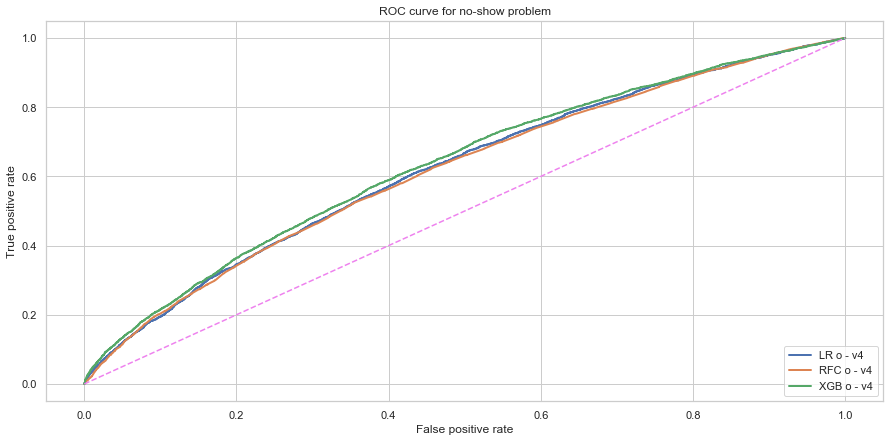

In [29]:
# Compare ROCs for:
fpr13, tpr13, thresholds13 = roc_curve(yv4_test, yv4_test_LR_o_prob) # LR
fpr14, tpr14, thresholds14 = roc_curve(yv4_test, yv4_test_RFC_o_prob) # RFC
fpr15, tpr15, thresholds15 = roc_curve(yv4_test, yv4_test_XGB_o_prob) # XGB


plt.figure(figsize=(15,7))

plt.plot(fpr13, tpr13,lw=2,label='LR o - v4')
plt.plot(fpr14, tpr14,lw=2,label='RFC o - v4')
plt.plot(fpr15, tpr15,lw=2,label='XGB o - v4')

plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for no-show problem');

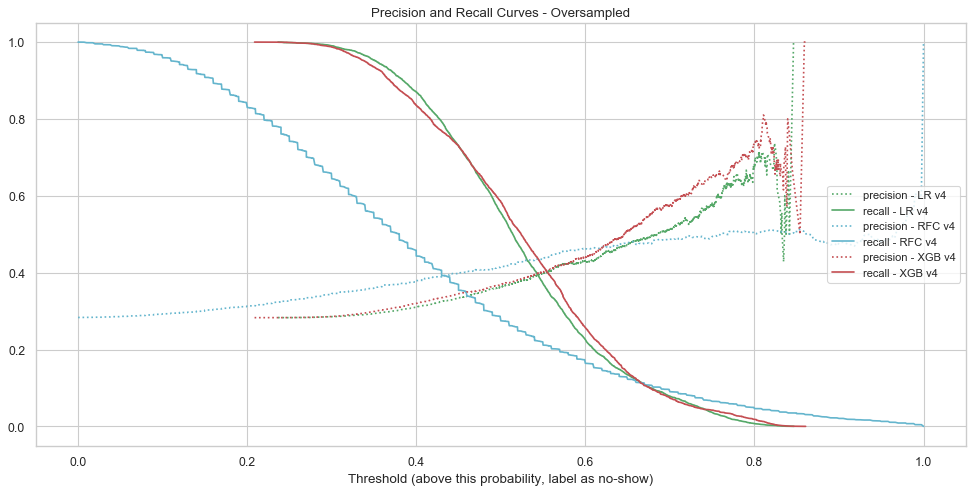

In [36]:
# Compare Precision/Recall curves
precision_curve2, recall_curve2, threshold_curve2 = precision_recall_curve(yv4_test, yv4_test_LR_o_prob)
precision_curve4, recall_curve4, threshold_curve4 = precision_recall_curve(yv4_test, yv4_test_RFC_o_prob)
precision_curve5, recall_curve5, threshold_curve5 = precision_recall_curve(yv4_test, yv4_test_XGB_o_prob)

plt.figure(dpi=80,figsize=(15,7))
plt.plot(threshold_curve2, precision_curve2[1:],label='precision - LR v4',color='g',linestyle=':')
plt.plot(threshold_curve2, recall_curve2[1:], label='recall - LR v4',color='g')
plt.plot(threshold_curve4, precision_curve4[1:],label='precision - RFC v4',color='c',linestyle=':')
plt.plot(threshold_curve4, recall_curve4[1:], label='recall - RFC v4',color='c')
plt.plot(threshold_curve5, precision_curve5[1:],label='precision - XGB v4',color='r',linestyle=':')
plt.plot(threshold_curve5, recall_curve5[1:], label='recall - XGB v4',color='r')
plt.legend(loc='center right',fontsize='small')
plt.xlabel('Threshold (above this probability, label as no-show)');
plt.title('Precision and Recall Curves - Oversampled');

### Ensembling

In [10]:
# create voting classifier
model_list = [('LR',eval('LR')),('RFC',eval('RFC'))]

def ensembling(X_train,y_train,X_test,y_test,vote_type,weights):
    voting_classifer = VotingClassifier(estimators=model_list,
                                        voting=vote_type,
                                        weights = weights,
                                        n_jobs=-1)
    voting_classifer.fit(X_train, y_train)

    yv2_test_VC = voting_classifer.predict_proba(X_test)
#     yv2_test_VC, yv2_test_VC_prob = voting_classifer.predict(Xv2_test), voting_classifer.predict_proba(Xv2_test)[:,1]
    return print_scores(y_test, yv2_test_VC)

NameError: name 'LR' is not defined

In [69]:
ensembling(Xv4_resampled,yv4_resampled,Xv4_test,yv4_test,'soft',['0.7','0.3'])

TypeError: cannot perform reduce with flexible type

In [67]:
# using the new threshold
threshold = 0.4
y_predict = (LR.predict_proba(Xv4_test)[:,1] > threshold)
print(f"Threshold of {threshold}:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(yv4_test, y_predict), 
                                                     recall_score(yv4_test, y_predict)))

Threshold of 0.4:
Precision: 0.3103,   Recall: 0.8700
